In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler



In [2]:
data = pd.read_parquet('data/BBAG-cross.parquet')
data = data[data.country != 'Slovakia'].reset_index(drop =  True)

## Permutation test

In [3]:

SEED = 42
SCALE_RANGE = (0.05, 0.95)
np.random.seed(SEED)

def fit_logit_scaled_single(df, predictor, y, scale_range=SCALE_RANGE):
    X_raw = df[[predictor]].astype(float)

    scaler = MinMaxScaler(feature_range=scale_range)
    X_scaled = scaler.fit_transform(X_raw.values)

    X = sm.add_constant(X_scaled, has_constant="add")
    res = sm.Logit(y, X).fit(disp=0)
    return res


def permute_within_country_pvalue_single(
    df: pd.DataFrame,
    predictor: str,
    n_perm: int = 1000,
    seed: int = 42,
    ycol: str = "GAP_bin",
    country_col: str = "country",
    scale_range=SCALE_RANGE,
):
    rng = np.random.default_rng(seed)

    d = (
        df[[country_col, predictor, ycol]].dropna()
        .reset_index(drop=True)
    )

    y0 = d[ycol].astype(int).to_numpy()

    res_obs = fit_logit_scaled_single(d, predictor, y0, scale_range)
    beta_obs = float(res_obs.params[1]) 

    idx_by_country = {
        c: np.where(d[country_col].to_numpy() == c)[0]
        for c in d[country_col].unique()
    }

    betas_perm = np.empty(n_perm, dtype=float)

    for p in range(n_perm):
        y_perm = y0.copy()
        for idx in idx_by_country.values():
            y_perm[idx] = rng.permutation(y_perm[idx])

        res_p = fit_logit_scaled_single(d, predictor, y_perm, scale_range)
        betas_perm[p] = float(res_p.params[1])


    p_value = (np.sum(np.abs(betas_perm) >= abs(beta_obs)) + 1) / (n_perm + 1)

    return p_value, beta_obs, betas_perm


In [4]:
predictors = ["Mono", "One", "Two", "Three", "Total"]

rows = []
for pred in predictors:
    p_value, beta_obs, betas_perm = permute_within_country_pvalue_single(
        data,
        predictor=pred,
        n_perm=1000,
        seed=42
    )
    rows.append({
        "Predictor": pred,
        "p_value": p_value
    })

perm_results = pd.DataFrame(rows).sort_values("p_value").reset_index(drop=True)
perm_results


,Predictor,p_value
0,Mono,0.000999
1,One,0.000999
2,Two,0.000999
3,Three,0.000999
4,Total,0.000999


In [5]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler

SEED = 42
SCALE_RANGE = (0.05, 0.95)

def fit_logit_scaled_single(df, predictor, y, scale_range=SCALE_RANGE):
    X_raw = df[[predictor]].astype(float)

    scaler = MinMaxScaler(feature_range=scale_range)
    X_scaled = scaler.fit_transform(X_raw.values)

    X = sm.add_constant(X_scaled, has_constant="add")
    res = sm.Logit(y, X).fit(disp=0)
    return res

def permute_within_country_pvalue_single(
    df: pd.DataFrame,
    predictor: str,
    n_perm: int = 1000,
    seed: int = 42,
    ycol: str = "GAP_bin",
    country_col: str = "country",
    scale_range=SCALE_RANGE,
):
    rng = np.random.default_rng(seed)

    d = df[[country_col, predictor, ycol]].dropna().reset_index(drop=True)
    y0 = d[ycol].astype(int).to_numpy()

    res_obs = fit_logit_scaled_single(d, predictor, y0, scale_range)
    beta_obs = float(res_obs.params[1])

    idx_by_country = {
        c: np.where(d[country_col].to_numpy() == c)[0]
        for c in d[country_col].unique()
    }

    betas_perm = np.empty(n_perm, dtype=float)

    for p in range(n_perm):
        y_perm = y0.copy()
        for idx in idx_by_country.values():
            y_perm[idx] = rng.permutation(y_perm[idx])

        res_p = fit_logit_scaled_single(d, predictor, y_perm, scale_range)
        betas_perm[p] = float(res_p.params[1])

    p_value = (np.sum(np.abs(betas_perm) >= abs(beta_obs)) + 1) / (n_perm + 1)
    return p_value, beta_obs, betas_perm

def loco_permutation_test_single(
    df: pd.DataFrame,
    predictor: str,
    n_perm: int = 1000,
    seed: int = 42,
    ycol: str = "GAP_bin",
    country_col: str = "country",
    scale_range=SCALE_RANGE,
):
    # Dataset base (solo columnas necesarias)
    d0 = df[[country_col, predictor, ycol]].dropna().reset_index(drop=True)

    countries = d0[country_col].unique()
    rows = []

    for left_out in countries:
        d_train = d0[d0[country_col] != left_out].reset_index(drop=True)

        # Si queda un país con un solo valor de y (todo 0 o todo 1), Logit puede fallar
        y_train = d_train[ycol].astype(int).to_numpy()
        if np.unique(y_train).size < 2:
            rows.append({
                "Predictor": predictor,
                "LeftOutCountry": left_out,
                "p_value": np.nan,
                "beta_obs": np.nan,
                "n_train": d_train.shape[0],
                "note": "Skipped: y has no variation in training set"
            })
            continue

        pval, beta_obs, betas_perm = permute_within_country_pvalue_single(
            d_train,
            predictor=predictor,
            n_perm=n_perm,
            seed=seed,
            ycol=ycol,
            country_col=country_col,
            scale_range=scale_range
        )

        rows.append({
            "Predictor": predictor,
            "LeftOutCountry": left_out,
            "p_value": pval,
            "beta_obs": beta_obs,
            "n_train": d_train.shape[0],
            "note": ""
        })

    return pd.DataFrame(rows)

# --- Ejecutar LOCO para todos los predictores ---
predictors = ["Mono", "One", "Two", "Three", "Total"]

all_loco = []
for pred in predictors:
    df_loco = loco_permutation_test_single(
        data,
        predictor=pred,
        n_perm=1000,
        seed=42,
        ycol="GAP_bin",
        country_col="country",
        scale_range=SCALE_RANGE
    )
    all_loco.append(df_loco)

loco_results = pd.concat(all_loco, ignore_index=True)

# Resumen tipo "robustez": p-value mediano y % de folds significativos por predictor
alpha = 0.05
summary = (
    loco_results
    .groupby("Predictor", as_index=False)
    .agg(
        n_folds=("p_value", lambda s: s.notna().sum()),
        p_median=("p_value", "median"),
        p_min=("p_value", "min"),
        frac_sig=("p_value", lambda s: np.mean(s.dropna() < alpha) if s.notna().any() else np.nan),
        beta_median=("beta_obs", "median"),
    )
    .sort_values(["p_median", "p_min"])
    .reset_index(drop=True)
)

loco_results, summary


(    Predictor LeftOutCountry   p_value  beta_obs  n_train note
 0        Mono        Austria  0.000999  0.735591    79807     
 1        Mono        Belgium  0.000999  0.817869    79185     
 2        Mono        Czechia  0.000999  0.730481    78552     
 3        Mono    Switzerland  0.000999  0.721283    81493     
 4        Mono        Germany  0.000999  0.751120    79560     
 ..        ...            ...       ...       ...      ...  ...
 125     Total        Finland  0.000999 -0.813053    82145     
 126     Total      Lithuania  0.000999 -0.753366    82094     
 127     Total         Latvia  0.000999 -0.772022    82443     
 128     Total          Malta  0.000999 -0.754146    82868     
 129     Total        Romania  0.000999 -0.812901    82044     
 
 [130 rows x 6 columns],
   Predictor  n_folds  p_median     p_min  frac_sig  beta_median
 0      Mono       26  0.000999  0.000999       1.0     0.753507
 1       One       26  0.000999  0.000999       1.0    -0.270616
 2     Thr

In [6]:
summary

,Predictor,n_folds,p_median,p_min,frac_sig,beta_median
0,Mono,26,0.000999,0.000999,1.0,0.753507
1,One,26,0.000999,0.000999,1.0,-0.270616
2,Three,26,0.000999,0.000999,1.0,-0.413909
3,Total,26,0.000999,0.000999,1.0,-0.753756
4,Two,26,0.000999,0.000999,1.0,-0.619964


In [7]:
loco_results

,Predictor,LeftOutCountry,p_value,beta_obs,n_train,note
0,Mono,Austria,0.000999,0.735591,79807,
1,Mono,Belgium,0.000999,0.817869,79185,
2,Mono,Czechia,0.000999,0.730481,78552,
3,Mono,Switzerland,0.000999,0.721283,81493,
4,Mono,Germany,0.000999,0.751120,79560,
...,...,...,...,...,...,...
125,Total,Finland,0.000999,-0.813053,82145,
126,Total,Lithuania,0.000999,-0.753366,82094,
127,Total,Latvia,0.000999,-0.772022,82443,
128,Total,Malta,0.000999,-0.754146,82868,


## Plots Linears

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats

# --------------------
# Global style (journal-friendly)
# --------------------
mpl.rcParams.update({
    "font.family": "Arial",
    "font.size": 11,
    "axes.titlesize": 13,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10,
    "figure.titlesize": 14,
    "axes.linewidth": 1.0
})

COLOR_MONO = "#d62728"    
COLOR_TOTAL = "#1f77b4"  
COLOR_FIT = "#111111"    # near-black
GRID_ALPHA = 0


COL_COUNTRY = "country"
COL_GAP = "GAP_corrected"
COL_MONO = "Mono"
COL_TOTAL = "Proficiency"

# --------------------
# Load & clean
# --------------------
df = data.copy()

required = [COL_COUNTRY, COL_GAP, COL_MONO, COL_TOTAL]

for c in [COL_GAP, COL_MONO, COL_TOTAL]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

df = df.dropna(subset=required)

# --------------------
# Aggregate at country level (correct level!)
# --------------------
country_df = (
    df.groupby(COL_COUNTRY)
      .agg(
          mean_gap=(COL_GAP, "mean"),
          mean_mono=(COL_MONO, "mean"),
          mean_total=(COL_TOTAL, "mean"),
          n=(COL_GAP, "size"),
      )
      .reset_index()
)

# --------------------
# Stats helpers
# --------------------
def corr_text(x, y):
    pear = stats.pearsonr(x, y)
    spear = stats.spearmanr(x, y)
    return (pear.statistic, pear.pvalue, spear.statistic, spear.pvalue)

def add_fit_line(ax, x, y, color=COLOR_FIT):
    slope, intercept, r, p, se = stats.linregress(x, y)
    xline = np.linspace(np.min(x), np.max(x), 200)
    yline = intercept + slope * xline
    ax.plot(xline, yline, linewidth=2, color=color)
    return r, p, slope

def annotate_points(ax, x, y, labels):
    # Small offsets so labels don't sit exactly on points
    dx = 0.004 * (np.max(x) - np.min(x) + 1e-9)
    dy = 0.004 * (np.max(y) - np.min(y) + 1e-9)
    for xi, yi, lab in zip(x, y, labels):
        ax.text(xi + dx, yi + dy, str(lab), fontsize=9)

def quartile_summary(series, values, labels):
    q = pd.qcut(series, 5, labels=labels)
    tmp = pd.DataFrame({"q": q, "val": values})
    out = (tmp.groupby("q")
              .agg(mean=("val", "mean"),
                   sd=("val", "std"),
                   n=("val", "size"))
              .reset_index())
    out["se"] = out["sd"] / np.sqrt(out["n"])
    out["ci95"] = 1.96 * out["se"]
    return out

In [35]:
import statsmodels.formula.api as smf

# Modelo con fórmula (igual que en R)
gdp_lm = smf.ols('mean_gap ~ mean_mono', data=country_df).fit()

# Ver resumen (igual que summary() en R)
print(gdp_lm.summary())

                            OLS Regression Results                            
Dep. Variable:               mean_gap   R-squared:                       0.340
Model:                            OLS   Adj. R-squared:                  0.312
Method:                 Least Squares   F-statistic:                     12.35
Date:                Mon, 26 Jan 2026   Prob (F-statistic):            0.00178
Time:                        17:06:41   Log-Likelihood:                -30.743
No. Observations:                  26   AIC:                             65.49
Df Residuals:                      24   BIC:                             68.00
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.8298      0.274     -3.026      0.0

In [12]:
mono_q

,q,mean,sd,n,se,ci95
0,Q1 (low),-0.688434,0.847616,7,0.320369,0.627922
1,Q2,-0.293854,0.694640,6,0.283586,0.555828
2,Q3,-0.196474,0.454079,6,0.185377,0.363339
3,Q4 (high),0.922808,1.066339,7,0.403038,0.789955


In [13]:
total_q

,q,mean,sd,n,se,ci95
0,Q1 (low),0.844655,0.981946,7,0.371141,0.727436
1,Q2,-0.521657,0.332417,6,0.135709,0.265989
2,Q3,0.247233,0.871435,6,0.355762,0.697293
3,Q4 (high),-0.795341,0.712825,7,0.269423,0.528068


In [33]:
country_df

,country,mean_gap,mean_mono,mean_total,n
0,Austria,-0.442462,19.048852,30.706586,4320
1,Belgium,-0.811490,32.969175,28.678288,4942
2,Bulgaria,-0.278687,50.914584,26.275644,1953
3,Croatia,-0.459236,27.338766,25.906862,2798
4,Cyprus,-0.246247,9.753444,39.134869,1205
5,Czechia,0.411196,26.883741,15.180371,5575
6,Denmark,-0.967989,5.906286,41.561671,2609
7,Estonia,0.826651,11.325468,30.360990,7522
8,Finland,0.671063,7.928120,36.104827,1982
9,France,0.400285,37.937006,19.925921,3640


In [ ]:
ax3.errorbar(
    mono_q["q"], mono_q["mean"], yerr=mono_q["ci95"],
    fmt="o-", capsize=4, linewidth=2, markersize=7,
    color=COLOR_MONO, ecolor="black"
)

In [21]:
mono_q

,q,mean,sd,n,se,ci95
0,D1,-0.688434,0.847616,7,0.320369,0.627922
1,D2,-0.293854,0.694640,6,0.283586,0.555828
2,D3,-0.196474,0.454079,6,0.185377,0.363339
3,D4,0.922808,1.066339,7,0.403038,0.789955


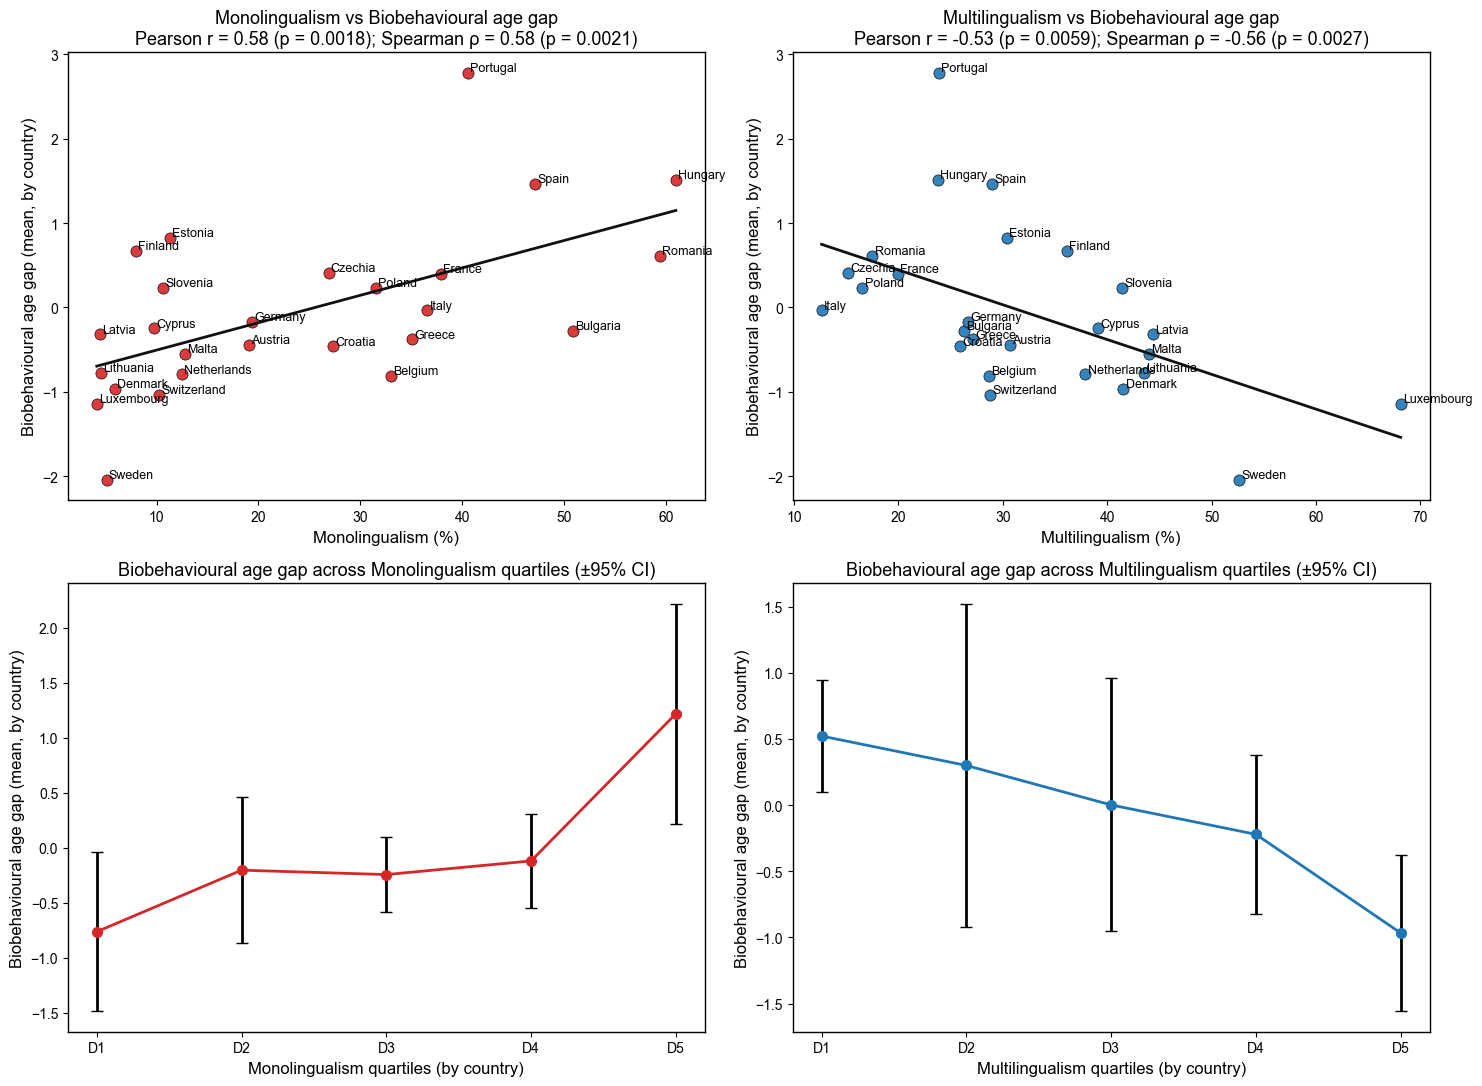

In [31]:
# --------------------
# Prepare correlations
# --------------------
x_mono = country_df["mean_mono"].to_numpy()
x_total = country_df["mean_total"].to_numpy()
y_gap = country_df["mean_gap"].to_numpy()
labels = country_df[COL_COUNTRY].astype(str).to_list()

r_mono, p_mono, rho_mono, ps_mono = corr_text(x_mono, y_gap)
r_total, p_total, rho_total, ps_total = corr_text(x_total, y_gap)

# Quartiles
# Deciles (10-quantiles)
labels_10 = [f"D{i}" for i in range(1, 6)]

mono_q = quartile_summary(
    country_df["mean_mono"],
    country_df["mean_gap"],
    labels=labels_10
)

total_q = quartile_summary(
    country_df["mean_total"],
    country_df["mean_gap"],
    labels=labels_10
)


# --------------------
# Plot: one figure, 4 panels
# --------------------
fig, axes = plt.subplots(2, 2, figsize=(15, 11))
ax1, ax2, ax3, ax4 = axes.flatten()

# (1) Monolingualism scatter with labels + fit
ax1.scatter(
    x_mono, y_gap,
    s=65, alpha=0.9,
    edgecolor="black", linewidth=0.5,
    color=COLOR_MONO
)
annotate_points(ax1, x_mono, y_gap, labels)
add_fit_line(ax1, x_mono, y_gap)

ax1.set_xlabel("Monolingualism (%)")
ax1.set_ylabel("Biobehavioural age gap (mean, by country)")
ax1.set_title(
    "Monolingualism vs Biobehavioural age gap\n"
    f"Pearson r = {r_mono:.2f} (p = {p_mono:.2g}); Spearman ρ = {rho_mono:.2f} (p = {ps_mono:.2g})"
)
ax1.grid(alpha=GRID_ALPHA)




# (2) Multilingualism scatter with labels + fit
ax2.scatter(
    x_total, y_gap,
    s=65, alpha=0.9,
    edgecolor="black", linewidth=0.5,
    color=COLOR_TOTAL
)
annotate_points(ax2, x_total, y_gap, labels)
add_fit_line(ax2, x_total, y_gap)

ax2.set_xlabel("Multilingualism (%)")
ax2.set_ylabel("Biobehavioural age gap (mean, by country)")
ax2.set_title(
    "Multilingualism vs Biobehavioural age gap\n"
    f"Pearson r = {r_total:.2f} (p = {p_total:.2g}); Spearman ρ = {rho_total:.2f} (p = {ps_total:.2g})"
)
ax2.grid(alpha=GRID_ALPHA)




# (3) Monolingualism quartiles (mean ± 95% CI)
ax3.errorbar(
    mono_q["q"], mono_q["mean"], yerr=mono_q["ci95"],
    fmt="o-", capsize=4, linewidth=2, markersize=7,
    color=COLOR_MONO, ecolor="black"
)
ax3.set_xlabel("Monolingualism quartiles (by country)")
ax3.set_ylabel("Biobehavioural age gap (mean, by country)")
ax3.set_title("Biobehavioural age gap across Monolingualism quartiles (±95% CI)")
ax3.grid(alpha=GRID_ALPHA)






# (4) Multilingualism quartiles (mean ± 95% CI)
ax4.errorbar(
    total_q["q"], total_q["mean"], yerr=total_q["ci95"],
    fmt="o-", capsize=4, linewidth=2, markersize=7,
    color=COLOR_TOTAL, ecolor="black"
)
ax4.set_xlabel("Multilingualism quartiles (by country)")
ax4.set_ylabel("Biobehavioural age gap (mean, by country)")
ax4.set_title("Biobehavioural age gap across Multilingualism quartiles (±95% CI)")
ax4.grid(alpha=GRID_ALPHA)

plt.tight_layout()
plt.show()